In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.2.0
GPU detected: []


# ###  Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/entity-annotated-corpus/ner.csv
/kaggle/input/entity-annotated-corpus/ner_dataset.csv
/kaggle/input/ner-datasetcsv/ner_dataset.csv


In [7]:
# Loading data
data = pd.read_csv('/kaggle/input/ner-datasetcsv/ner_dataset.csv',encoding='latin1')
data = data.fillna(method = 'ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [8]:
print("Unique words in corpus:",data['Word'].unique())
print("Unique Tags in corpus:",data['Tag'].unique())

Unique words in corpus: ['Thousands' 'of' 'demonstrators' ... 'indicative' '3700' 'Bermel']
Unique Tags in corpus: ['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


In [9]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [10]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [11]:
num_words, num_tags

(35179, 17)

# ******Retrieve Sentences and Corresponsing Tags

In [12]:
class SentanceGetter(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentances = [s for s in self.grouped]

In [13]:
getter = SentanceGetter(data)
sentances = getter.sentances

In [15]:
# checking the structure of sentances 
sentances[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

# ###  Define Mappings between Sentences and Tags

In [16]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = { t: i for i,t in enumerate(tags)}

In [17]:
word2idx

{'Avoid': 1,
 'Cameroonian': 2,
 'Bagosora': 3,
 'victories': 4,
 '1,70,000': 5,
 'Torrential': 6,
 'Made': 7,
 'inaccuracies': 8,
 'Hearings': 9,
 'Burdzhanadze': 10,
 'still': 11,
 'disabilities': 12,
 'jar': 13,
 'Zionism': 14,
 'silly': 15,
 'vampire': 16,
 'court-ordered': 17,
 'Zenani': 18,
 'divorced': 19,
 'postponing': 20,
 'reformer': 21,
 'clearly': 22,
 'humiliated': 23,
 'Hua': 24,
 'One': 25,
 'tapes': 26,
 'Glyn': 27,
 'surety': 28,
 'retaliatory': 29,
 'bacteria': 30,
 'striding': 31,
 'WAFA': 32,
 'Dadis': 33,
 'melt': 34,
 'impaired': 35,
 'al-Amiri': 36,
 'Celtic': 37,
 'Mauro': 38,
 'remotely': 39,
 'Tidjane': 40,
 'Mao': 41,
 'Humala': 42,
 'Mattel': 43,
 'museums': 44,
 'Marinus': 45,
 'flu-related': 46,
 'Shanwei': 47,
 'Richards': 48,
 'Seiken': 49,
 'alliance': 50,
 'Planica': 51,
 'architectural': 52,
 'vivanews.com': 53,
 'Decree': 54,
 'rating': 55,
 'liquids': 56,
 'Monte': 57,
 'shocks': 58,
 'overruled': 59,
 'option': 60,
 '141.9': 61,
 'long-successful'

# ### Padding Input Sentences and Creating Train/Test Splits

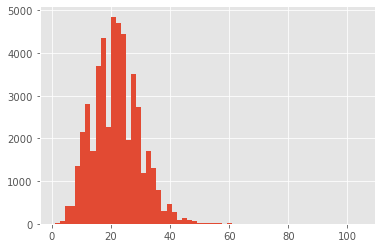

In [19]:
plt.hist([len(s) for s in sentances], bins=60)
plt.show()

In [50]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
max_len = 60
X = [[word2idx[w[0]] for w in s] for s in sentances]
X = pad_sequences(maxlen = max_len, sequences =X , padding ='post',value =num_words-1)
y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen=max_len,sequences =y,padding ='post',value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [51]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state =1)


# ### Build and Compile a Bidirectional LSTM Model

In [52]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [53]:
input_word = Input(shape = (max_len))
model = Embedding(input_dim = num_words,output_dim = max_len,input_length  = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100,return_sequences=True,recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags, activation ='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 60, 60)            2110740   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 60, 60)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 200)           128800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 60, 17)            3417      
Total params: 2,242,957
Trainable params: 2,242,957
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# ###  Train the Model

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [56]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=2,verbose = 1, mode ='max',restore_best_weights = True)
callbacks = early_stopping
history = model.fit( x_train,np.array(y_train), validation_split = 0.1, batch_size = 32,epochs = 20, verbose =1,callbacks=callbacks)


Epoch 1/20
960/960 [==============================] - 131s 136ms/step - loss: 0.1716 - accuracy: 0.9625 - val_loss: 0.0625 - val_accuracy: 0.9829
Epoch 2/20
960/960 [==============================] - 128s 134ms/step - loss: 0.0468 - accuracy: 0.9864 - val_loss: 0.0440 - val_accuracy: 0.9867
Epoch 3/20
960/960 [==============================] - 130s 135ms/step - loss: 0.0329 - accuracy: 0.9901 - val_loss: 0.0410 - val_accuracy: 0.9877
Epoch 4/20
960/960 [==============================] - 129s 135ms/step - loss: 0.0265 - accuracy: 0.9917 - val_loss: 0.0418 - val_accuracy: 0.9879
Epoch 5/20
960/960 [==============================] - 135s 141ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.0416 - val_accuracy: 0.9881
Epoch 6/20
960/960 [==============================] - 133s 138ms/step - loss: 0.0194 - accuracy: 0.9938 - val_loss: 0.0445 - val_accuracy: 0.9874
Epoch 00006: early stopping


# ### Evaluate Named Entity Recognition Model

In [35]:
model.evaluate(x_test,np.array(y_test))

150/150 [==============================] - 4s 26ms/step - loss: 0.0414 - accuracy: 0.9880


[0.04143928736448288, 0.9880316853523254]

In [ ]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'g',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'g',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [36]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis =-1)
y_true = np.argmax(np.array(y_test), axis =-1)[i]
print("{:15}{:5}\t {} \n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(x_test[i],y_true,p[0]):
    print("{:15}{}\t{}".format(words[w-1],tags[true],tags[pred]))

Word           True 	 Pred 

------------------------------
Nepalese       B-gpe	B-gpe
police         O	O
detained       O	O
41             O	O
Tibetans       B-gpe	B-gpe
Sunday         B-tim	I-tim
for            O	O
illegal        O	O
entry          O	O
into           O	O
the            O	O
country        O	O
.              O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005           O	O
2005